In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import torch
import torchvision.utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity
from torch import nn
import torch.nn.functional as F
from proj.show import imsshow
from proj.simple3dcnn import Simple3DCNN
from proj.resblock import ResBlock

## 读取第一题的数据并分隔

(200, 20, 192, 192) float32
(200, 20, 192, 192) float32


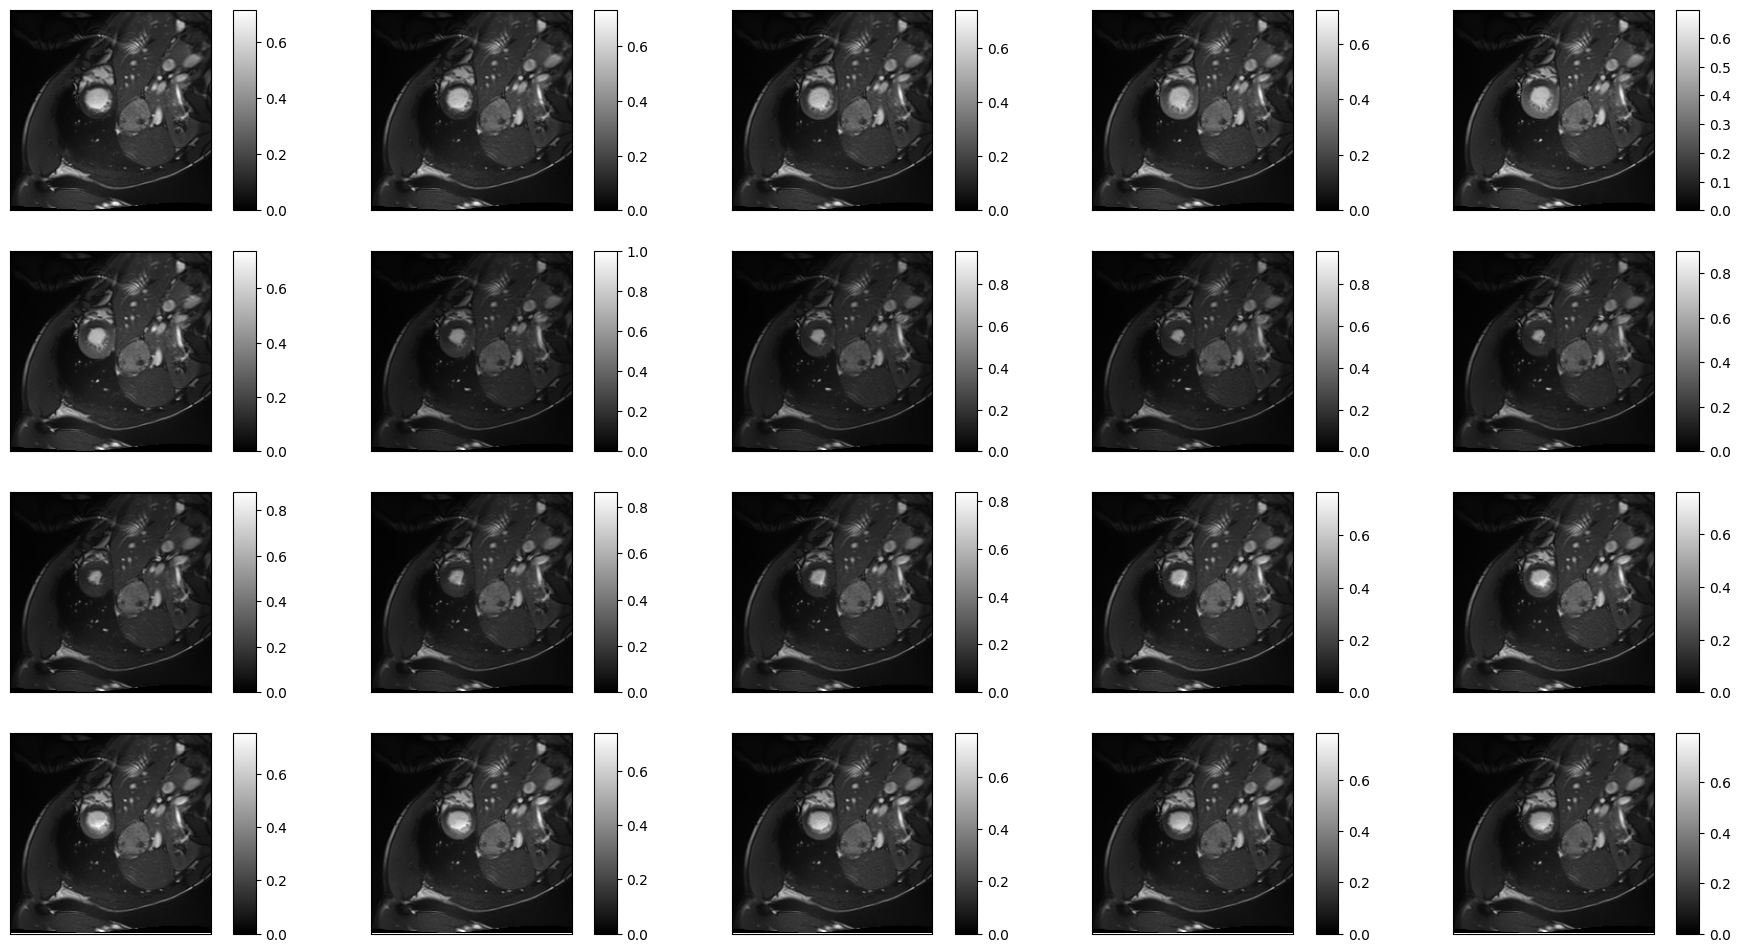

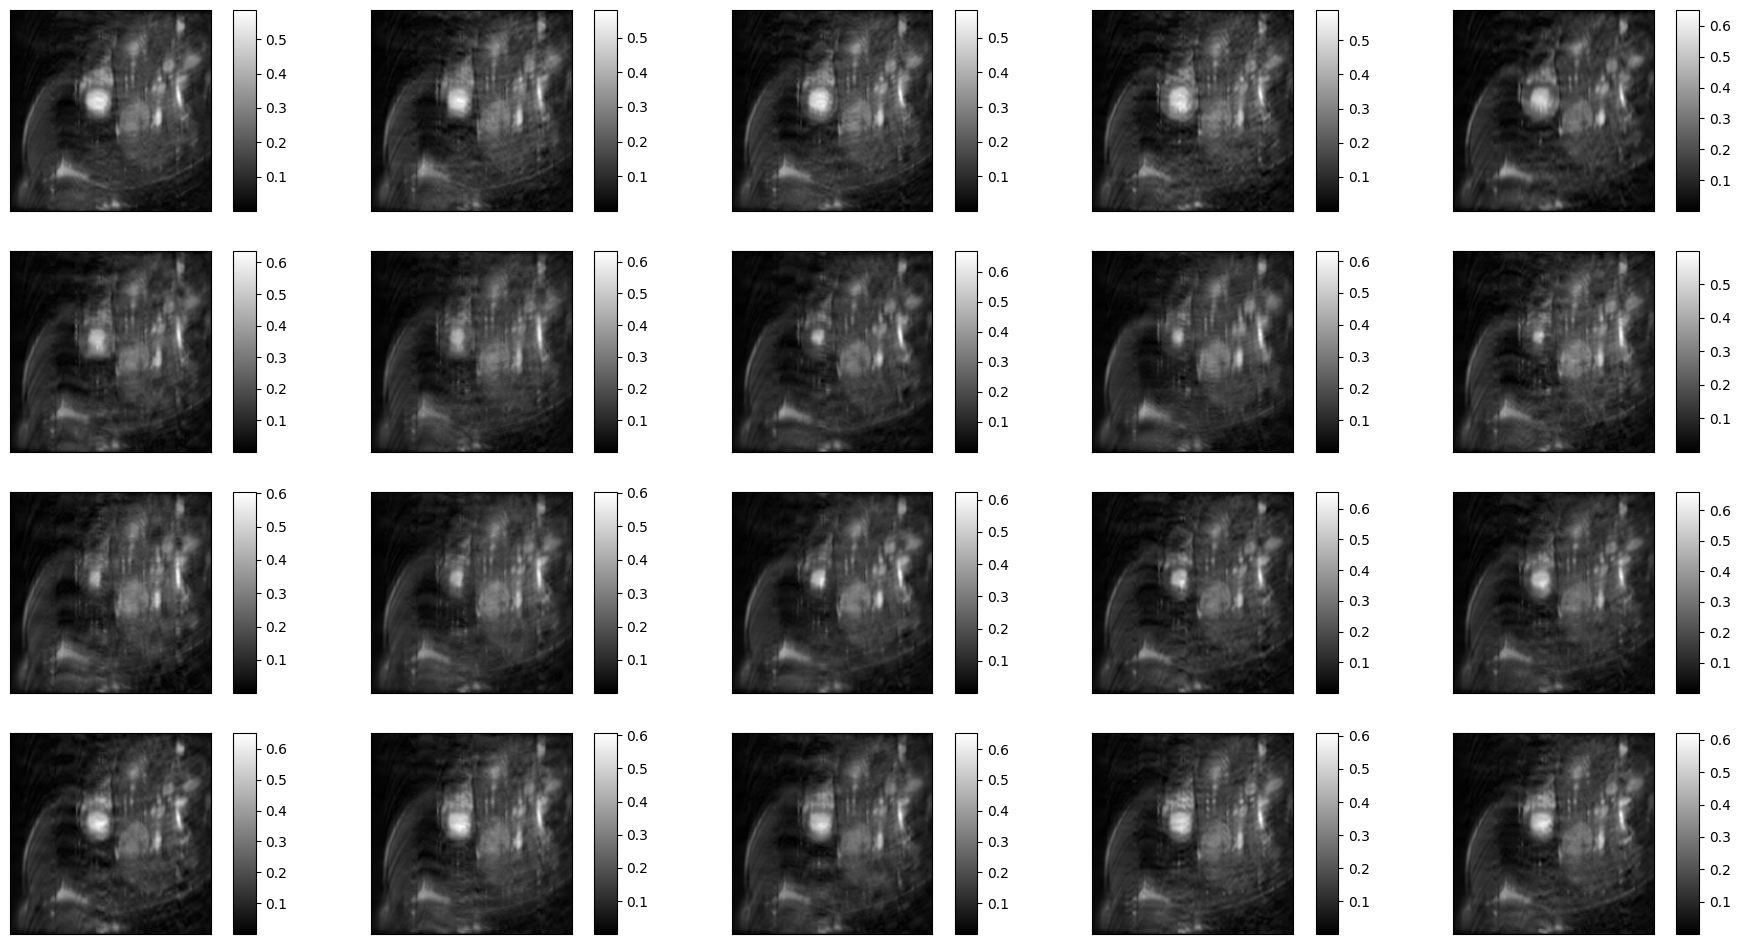

In [3]:
img_recon = np.load('data/data_after_prob1.npz')["recon"]
img_fully = np.load('data/cine.npz')['dataset']
print(img_fully.shape,img_fully.dtype)
print(img_recon.shape,img_recon.dtype)
imsshow(img_fully[0],num_col=5,cmap='gray', is_colorbar=True)
imsshow(img_recon[0],num_col=5,cmap='gray', is_colorbar=True)


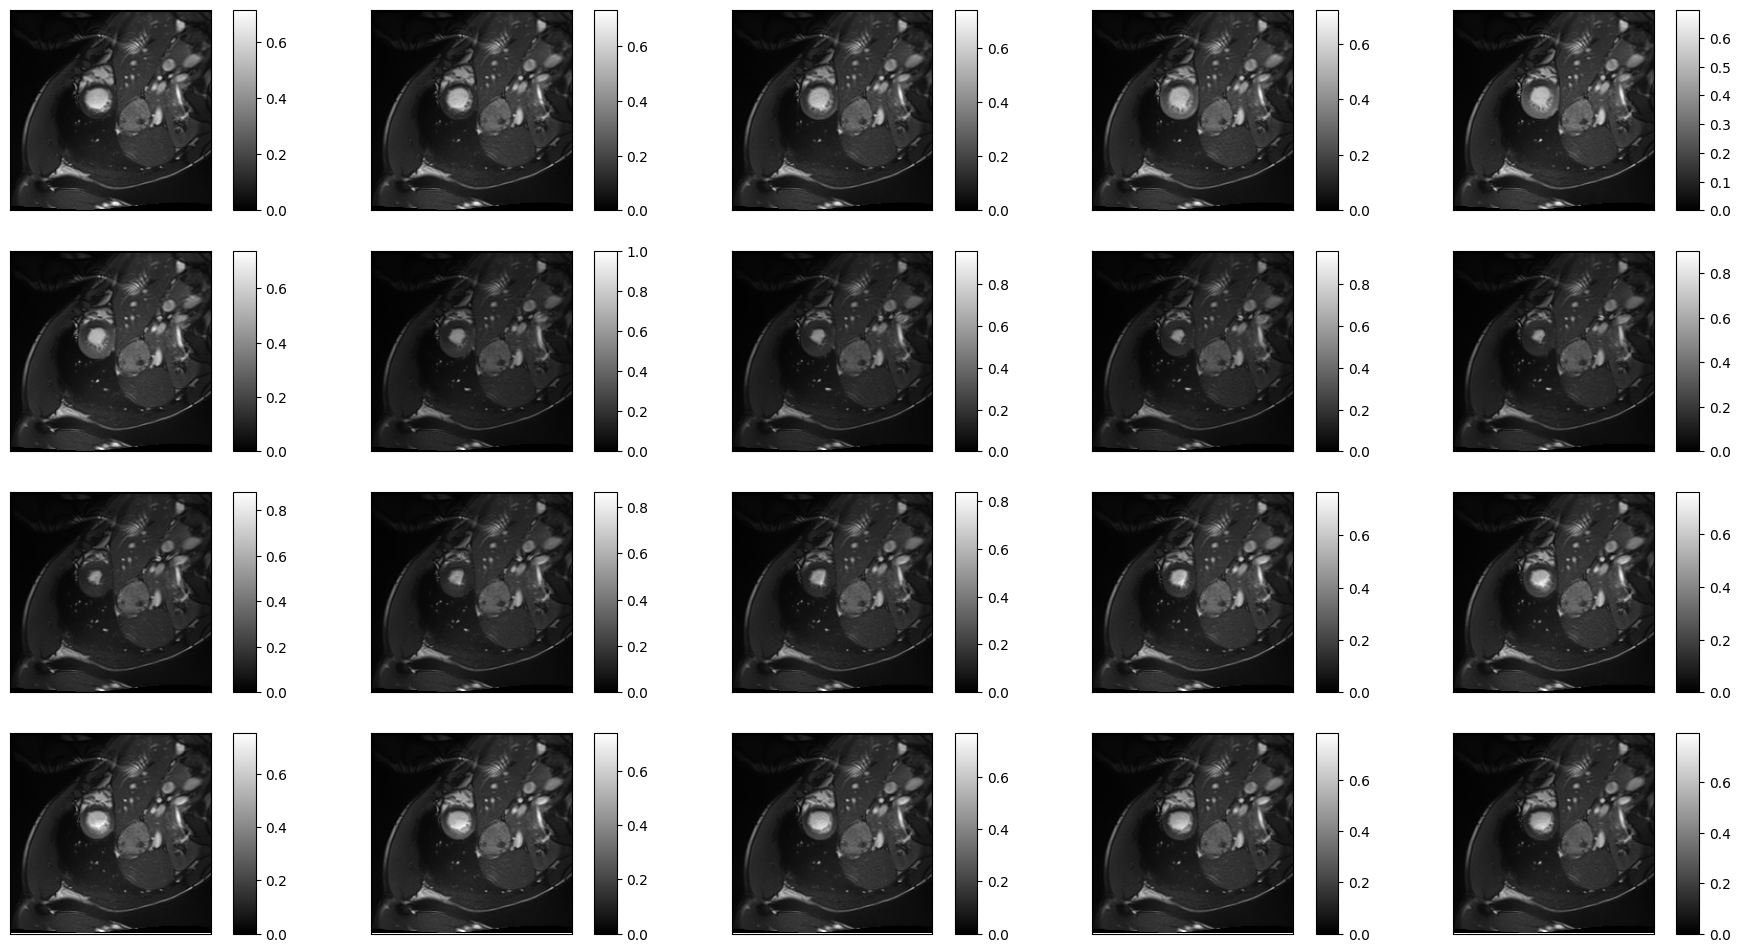

In [4]:
#对图像进行归一化处理
def normalize(img):
    img = (img - img.min()) / (img.max() - img.min()+1e-8)
    return img
img_fully = normalize(img_fully)
img_recon = normalize(img_recon)
imsshow(img_fully[0],num_col=5,cmap='gray', is_colorbar=True)

In [5]:
#将200个数据分割成5:1:2的训练（125）、验证（25）、测试集（50）
train_label = img_fully[:125]
train_data = img_recon[:125]
val_label = img_fully[125:150]
val_data = img_recon[125:150]
test_label = img_fully[150:]
test_data = img_recon[150:]

In [6]:
#把numpy数组转变成torch类型，构建loader
train_data = torch.from_numpy(train_data).float()
train_label = torch.from_numpy(train_label).float()
val_data = torch.from_numpy(val_data).float()
val_label = torch.from_numpy(val_label).float()
test_data = torch.from_numpy(test_data).float()
test_label = torch.from_numpy(test_label).float()
train = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_label), batch_size=5, shuffle=True)
val = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_data, val_label), batch_size=5, shuffle=True)
test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_label), batch_size=5, shuffle=True)

In [7]:
#计算validation的PSNR
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    val_loss = 0.0
    for i, data in enumerate(val, 0):
        data[0]=data[0].reshape(5,1,20,192,192)
        data[1]=data[1].reshape(5,1,20,192,192)
        inputs, labels =  data[0].to(device), data[1].to(device)
        outputs = inputs
        #20 * math.log10(max_intensity) - 10 * np.log10(compute_mse(reconstructed_im, target_im) + eps)
        val_loss += 20 * math.log10(1) - 10 * math.log10(criterion(outputs, labels).item()+1e-5)
    print(val_loss / len(val))

21.1077768620574


In [9]:
#计算validation的SSIM
with torch.no_grad():
    val_ssim = 0.0
    for i, data in enumerate(val, 0):
        data[0]=data[0].reshape(5,1,20,192,192)
        data[1]=data[1].reshape(5,1,20,192,192)
        inputs, labels =  data[0].to(device), data[1].to(device)
        outputs = inputs
        for j in range(5):
            val_ssim += structural_similarity(outputs[j][0].cpu().numpy(), labels[j][0].cpu().numpy(),data_range=1)
    print(val_ssim / len(val) / 5)

0.5653114328023248


In [34]:

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.resblock1 = ResBlock()
        self.resblock2 = ResBlock()
        self.resblock3 = ResBlock()
    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        return x

In [46]:
from proj.resblock import ResBlock, ResBlock_time
model=ResBlock_time()
print(model)

ResBlock_time(
  (conv2d1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2d1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1d1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,), groups=20)
  (conv2d3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d7): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up2d1): Upsample(scale_factor=2.0, mode=bilinear)
)


In [48]:

#训练resnet
import torch.optim as optim
# 检查是否有可用的GPU，如果有，则使用第一个可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# 实例化模型并移动到GPU
model = ResBlock_time().to(device)
#输出model参数
#print(model)
# 定义损失函数和优化器
#添加权重衰减
criterion = nn.MSELoss() 

optimizer = optim.Adam(model.parameters())#,  weight_decay=1e-3)
# 假设 train_loader 是你的数据加载器
# train_loader = DataLoader(...)

num_epochs = 100  # 设置训练的轮数

#计算validation的PSNR



# 训练循环
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    running_loss = 0.0
    for i, data in enumerate(train, 0):
        #print(data[0].shape)
        
        # 获取输入数据，并将数据移动到GPU,将输入数据reshape成(5,1,20, 192, 192)
        data[0]=data[0].reshape(5,1,20,192,192)
        data[1]=data[1].reshape(5,1,20,192,192)
        inputs, labels =  data[0].to(device), data[1].to(device)
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = model(inputs)
        
        # 计算损失
        loss = criterion(outputs, labels)

        # 反向传播
        loss.backward()

        # 优化
        optimizer.step()

    #在validation计算PSNR
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            val_loss = 0.0
            for i, data in enumerate(val, 0):
                data[0]=data[0].reshape(5,1,20,192,192)
                data[1]=data[1].reshape(5,1,20,192,192)
                inputs, labels =  data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                #20 * math.log10(max_intensity) - 10 * np.log10(compute_mse(reconstructed_im, target_im) + eps)
                val_loss += 20 * math.log10(1) - 10 * math.log10(criterion(outputs, labels).item()+1e-5)
            print(f"Validation PSNR: {val_loss / len(val)}")
    #在validation计算SSIM
        with torch.no_grad():
            val_ssim = 0.0
            for i, data in enumerate(val, 0):
                data[0]=data[0].reshape(5,1,20,192,192)
                data[1]=data[1].reshape(5,1,20,192,192)
                inputs, labels =  data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                for j in range(5):
                    val_ssim += structural_similarity(outputs[j][0].cpu().numpy(), labels[j][0].cpu().numpy(),data_range=1)
            print(f"Validation SSIM: {val_ssim / len(val) / 5}")
print('Finished Training')

Training on cuda:0
Epoch 1


KeyboardInterrupt: 

(192, 192)


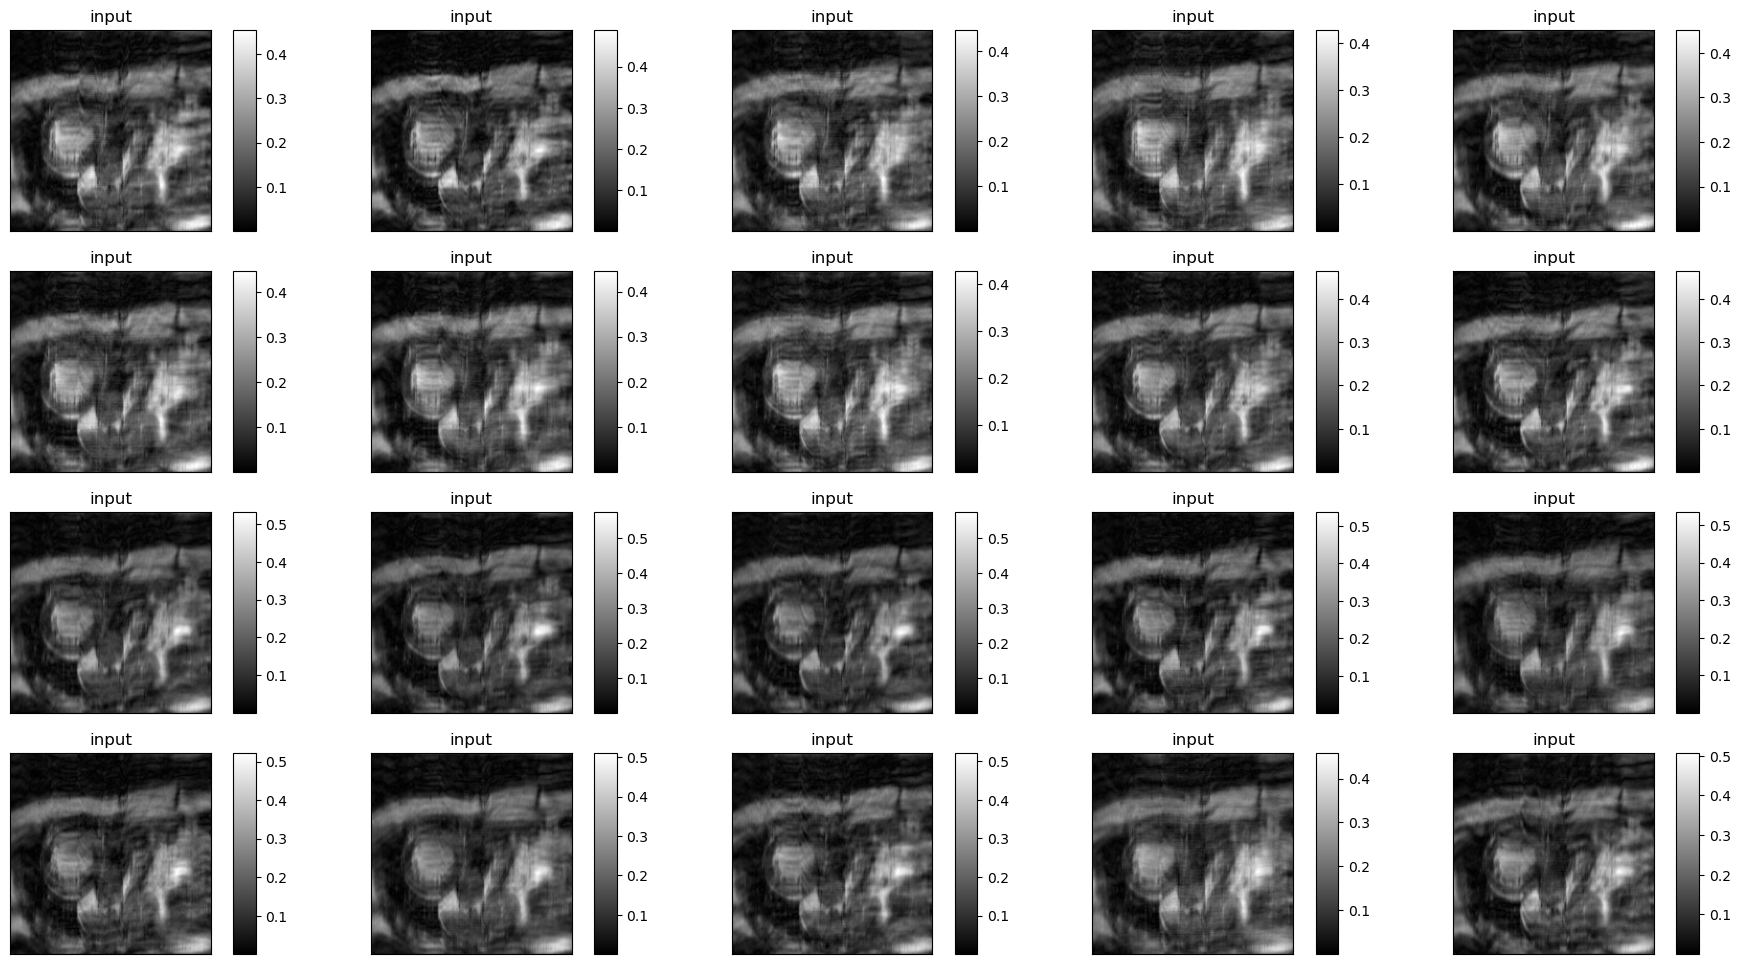

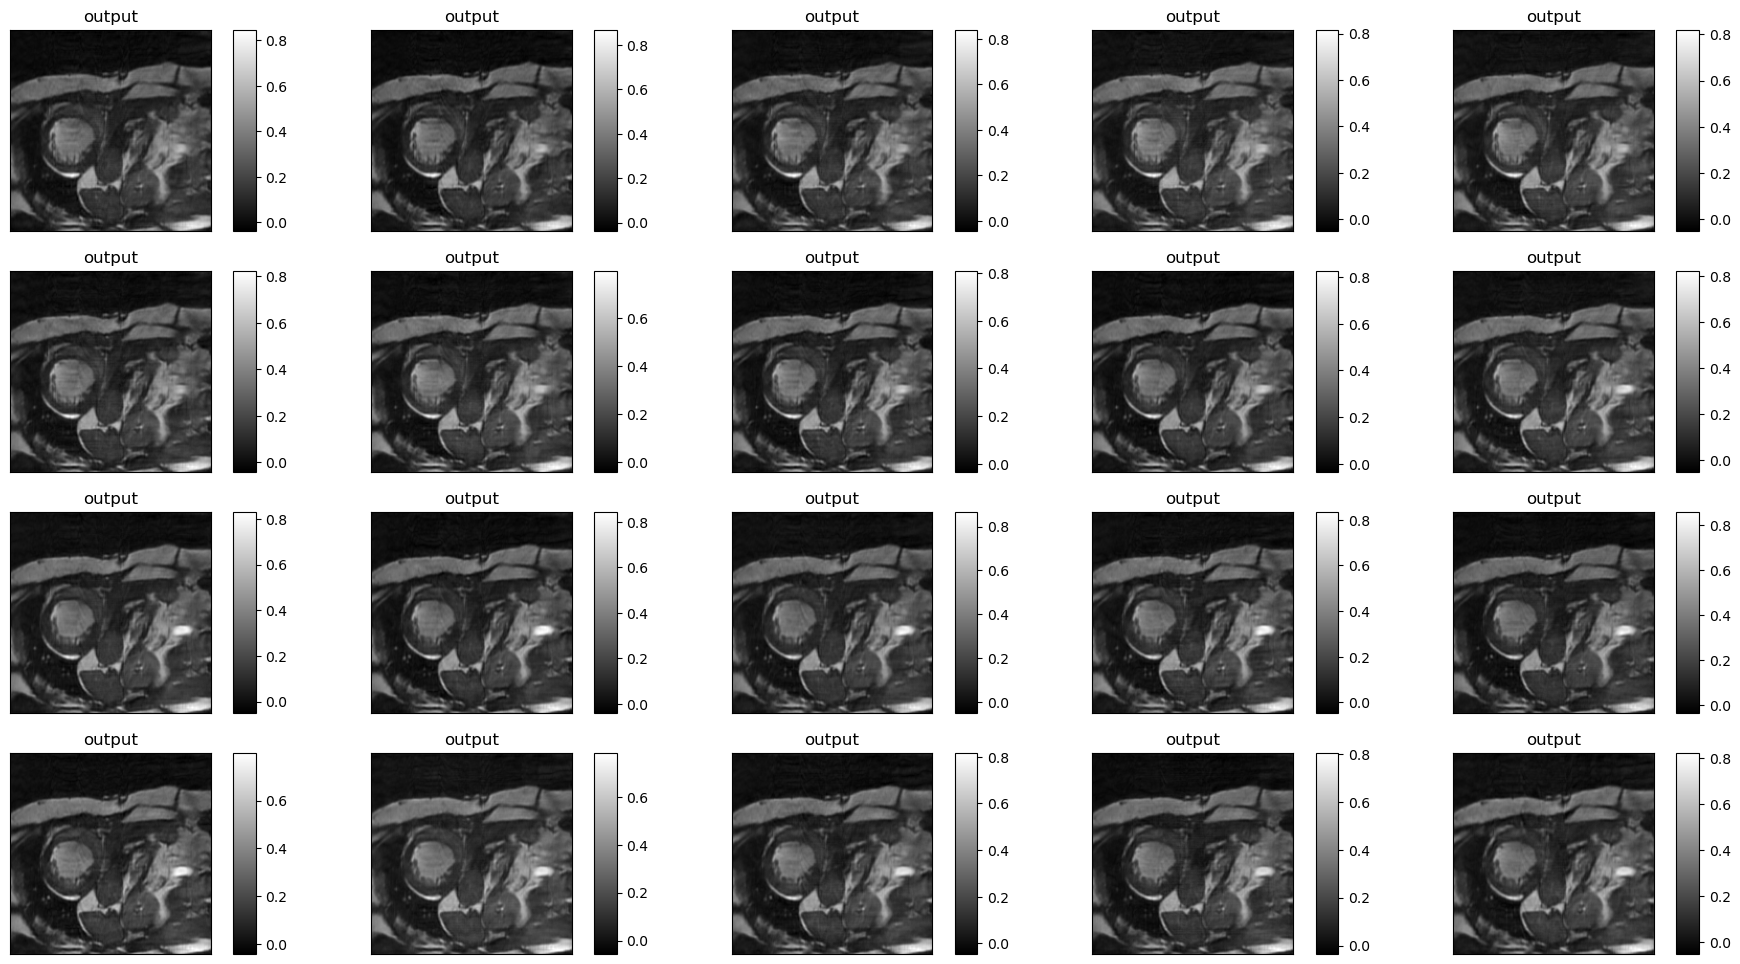

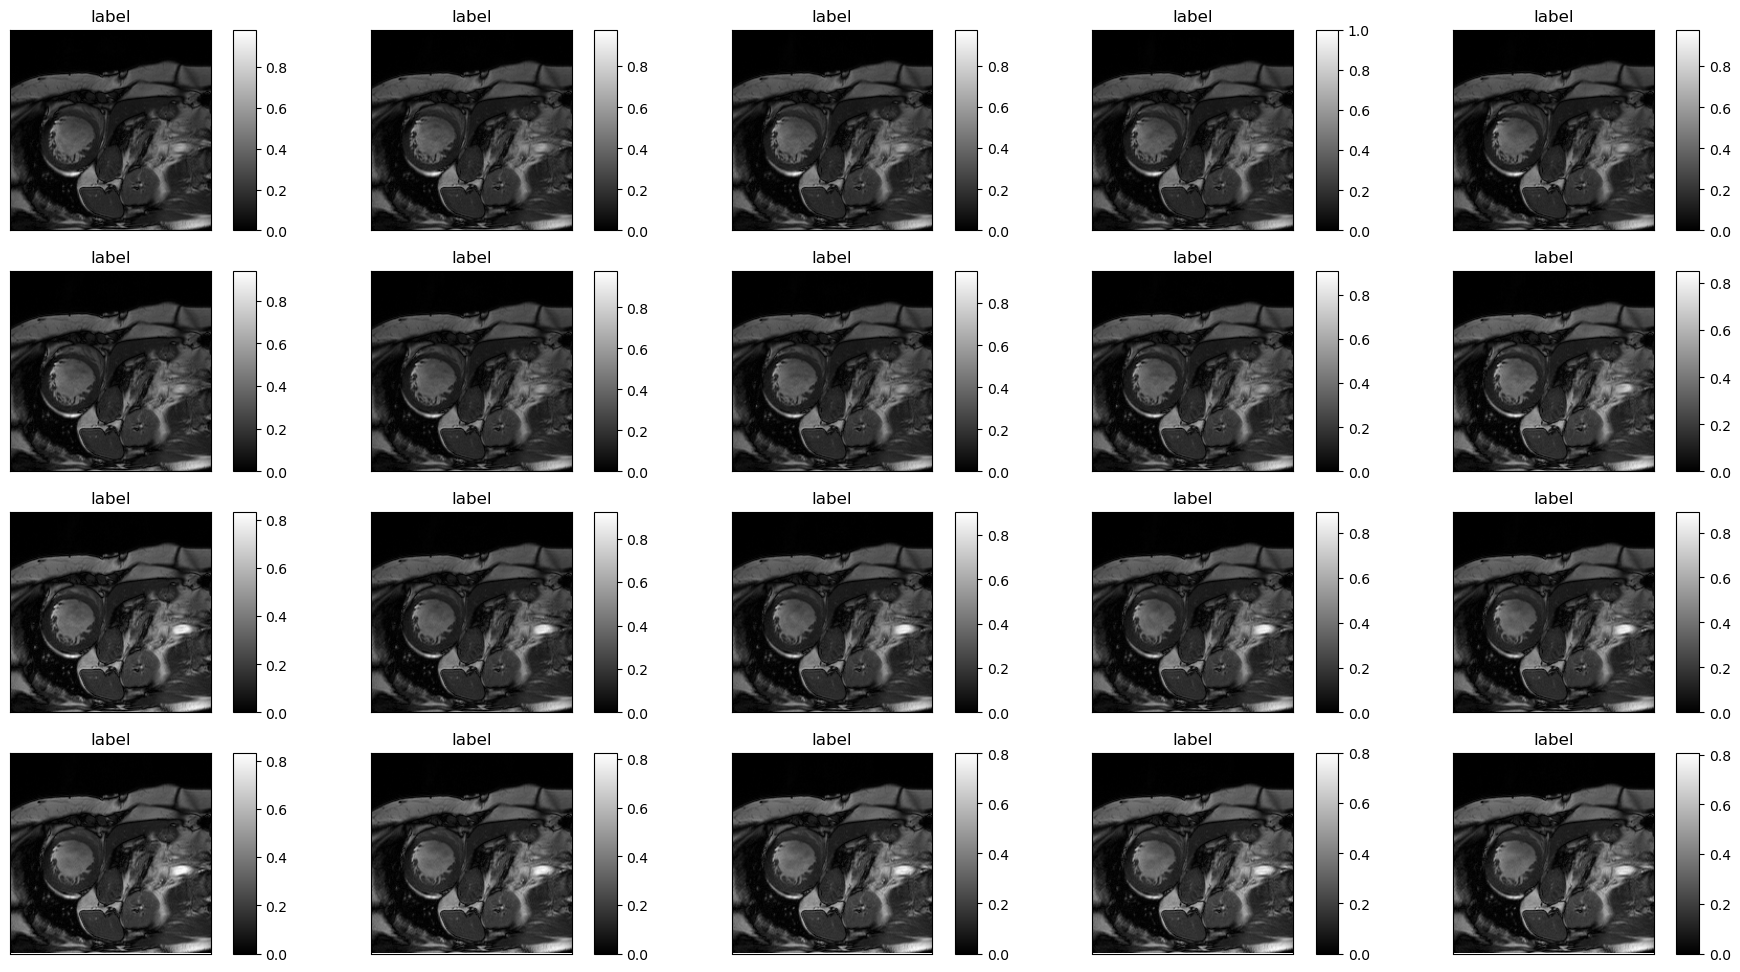

In [ ]:
#输出训练集的第一个数据
inputs, labels = test_data[0], test_label[0]
inputs=inputs.reshape(1,1,20,192,192)
labels=labels.reshape(1,1,20,192,192)
outputs = model(inputs.to(device))
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(1,20,192,192)
#input
print(outputs[0][0].shape)
imsshow (inputs[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["input"]*20)
imsshow(outputs[0],num_col=5,cmap='gray', is_colorbar=True,titles=["output"]*20)
imsshow(labels[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["label"]*20)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class DynamicFrameReconstructionModel(nn.Module):
    def __init__(self):
        super(DynamicFrameReconstructionModel, self).__init__()
        # 编码器部分: 2D CNN
        self.conv2d1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2d2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((18, 18))  # 降维到1x1
        
        # 编码器部分: 1D CNN
        # 假设全局平均池化后的每帧图像特征维度降低到32
        self.conv1d = nn.Conv1d(in_channels=10368, out_channels=10240, kernel_size=3, stride=1, padding=1)
        
        # 解码器部分
        # 首先将64维特征映射回更大的维度
        self.fc = nn.Linear(10240, 64 * 24 * 24)
        # 然后使用转置卷积层逐步上采样回原始尺寸
        #self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        #self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(16, 4, kernel_size=3, stride=2, padding=1, output_padding=1)
        #self.deconv5 = nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv6 = nn.ConvTranspose2d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        
        # 编码器: 2D CNN + 全局平均池化
        x = x.view(batch_size * seq_len, channels, height, width) #[100,1,192,192]
        x = F.relu(self.conv2d1(x)) #[100,16,192,192]
        x = self.pool(x) #[100,16,96,96]
        x = F.relu(self.conv2d2(x)) #[100,32,96,96]
        x = self.global_avg_pool(x)  # [100, 32, 1, 1]
        x = x.view(batch_size, seq_len, -1)  # [5, 20, 32]

        # 编码器: 1D CNN
        x = x.transpose(1, 2)  #[5, 32, 20]
        x = F.relu(self.conv1d(x)) # [5, 64, 20]
        x = x.transpose(1, 2)  # [5, 20, 64]

        # 解码器
        x = x.reshape(batch_size * seq_len, -1)  # [100, 64]
        x = F.relu(self.fc(x))  # [100, 128*3*3]
        x = x.view(-1, 64, 24, 24) # [100, 128, 3, 3]
        
        #x = F.relu(self.deconv1(x)) # [100, 64, 6, 6]
        #x = F.relu(self.deconv2(x)) # [100, 32, 12, 12]
        x = F.relu(self.deconv3(x)) # [100, 16, 24, 24]
        x = F.relu(self.deconv4(x)) # [100, 8, 48, 48]
        #x = F.relu(self.deconv5(x)) # [100, 4, 96, 96]
        x = torch.sigmoid(self.deconv6(x)) # [100, 1, 192, 192]
        #x = self.pool(x)
        x = x.view(batch_size, seq_len, 1, height, width)  # [batch_size, seq_len, 1, 192, 192]
        return x


# 实例化模型
model = DynamicFrameReconstructionModel()
input_tensor = torch.randn(5, 20, 1, 192, 192)  # 示例输入
output = model(input_tensor)

In [ ]:
from proj.resblock import ResBlock
#训练resnet
import torch.optim as optim
# 检查是否有可用的GPU，如果有，则使用第一个可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# 实例化模型并移动到GPU
model = DynamicFrameReconstructionModel().to(device)

# 定义损失函数和优化器
#添加权重衰减
criterion = nn.MSELoss() 

optimizer = optim.Adam(model.parameters())#,  weight_decay=1e-5)
# 假设 train_loader 是你的数据加载器
# train_loader = DataLoader(...)

num_epochs = 100  # 设置训练的轮数

#计算validation的PSNR



# 训练循环
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    running_loss = 0.0
    for i, data in enumerate(train, 0):
        #print(data[0].shape)
        
        # 获取输入数据，并将数据移动到GPU,将输入数据reshape成(5,1,20, 192, 192)
        data[0]=data[0].reshape(5,20,1,192,192)
        data[1]=data[1].reshape(5,20,1,192,192)
        inputs, labels =  data[0].to(device), data[1].to(device)
        # 清零梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = model(inputs)
        
        # 计算损失
        loss = criterion(outputs, labels)

        # 反向传播
        loss.backward()

        # 优化
        optimizer.step()

    #在validation计算PSNR
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            val_loss = 0.0
            for i, data in enumerate(val, 0):
                data[0]=data[0].reshape(5,20,1,192,192)
                data[1]=data[1].reshape(5,20,1,192,192)
                inputs, labels =  data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                #20 * math.log10(max_intensity) - 10 * np.log10(compute_mse(reconstructed_im, target_im) + eps)
                val_loss += 20 * math.log10(1) - 10 * math.log10(criterion(outputs, labels).item()+1e-5)
            print(f"Validation PSNR: {val_loss / len(val)}")
    #在validation计算SSIM
        # with torch.no_grad():
        #     val_ssim = 0.0
        #     for i, data in enumerate(val, 0):
        #         data[0]=data[0].reshape(5,20,1,192,192)
        #         data[1]=data[1].reshape(5,20,1,192,192)
        #         inputs, labels =  data[0].to(device), data[1].to(device)
        #         outputs = model(inputs)
        #         for j in range(5):
        #             val_ssim += structural_similarity(outputs[j][0].cpu().numpy(), labels[j][0].cpu().numpy())
        #     print(f"Validation SSIM: {val_ssim / len(val) / 5}")
print('Finished Training')

Training on cuda:0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Validation PSNR: 15.878309140759939
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Validation PSNR: 16.494763918835496
Epoch 11
Epoch 12


KeyboardInterrupt: 

In [ ]:
#输出训练集的第一个数据
inputs, labels = test_data[0], test_label[0]
inputs=inputs.reshape(1,20,1,192,192)
labels=labels.reshape(1,20,1,192,192)
outputs = model(inputs.to(device))
print(outputs.shape)
outputs = outputs.cpu().detach().numpy()
#input
print(outputs[0][0].shape)
imsshow (inputs[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["input"]*20)
imsshow(outputs[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["output"]*20)
imsshow(labels[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["label"]*20)